# 특정 주식 추출하기

In [62]:
from flask import Flask, render_template, request, jsonify
import time
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

main_url = "https://m.stock.naver.com/index.html#/domestic/stock/005930/price"
driver = webdriver.Chrome("C:/driver/chromedriver")
driver.get(main_url)
time.sleep(2)  
driver.implicitly_wait(1) 
driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
driver.implicitly_wait(1) 
driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')

data = []
columns = ['날짜','종가','전일대비','등락률','시가','고가','저가','거래량']
soup = BeautifulSoup(driver.page_source, "lxml" )
boxItems = soup.select("#content > div:nth-child(4) > div:nth-child(3) > div:nth-child(2) > div > div.VTablePrice_article__DfdmT > table > tbody")[0].select('tr')
driver.close()

In [63]:
for boxItem in boxItems:
    a = boxItem.select('td')
    row = dict()
    row = {"등록번호":'005930'}
    for k,v in list(zip(columns,a)):
        row[k] = v.text

    data.append(row)

In [69]:
data = data[::-1]

In [70]:
kospi_df = pd.DataFrame(data)
kospi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   등록번호    40 non-null     object
 1   날짜      40 non-null     object
 2   종가      40 non-null     object
 3   전일대비    40 non-null     object
 4   등락률     40 non-null     object
 5   시가      40 non-null     object
 6   고가      40 non-null     object
 7   저가      40 non-null     object
 8   거래량     40 non-null     object
dtypes: object(9)
memory usage: 2.9+ KB


In [71]:
for k,v in list(zip(range(0,9),kospi_df)):
    if not k in [0,1,3,4]:
        kospi_df[v] = kospi_df[v].apply(lambda x : int(int(x.replace(',', ''))))

In [72]:
from mpl_finance import candlestick2_ohlc
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from IPython.display import display

kospi_df.reset_index(drop = True,inplace = True)
kospi_df.set_index('날짜',inplace=True)
# kospi_df.reset_index(inplace = True)

kospi_df['MA3'] = kospi_df['종가'].rolling(3).mean()
kospi_df['MA5'] = kospi_df['종가'].rolling(5).mean()
kospi_df['MA10'] = kospi_df['종가'].rolling(10).mean()
kospi_df['MA20'] = kospi_df['종가'].rolling(20).mean()
display(kospi_df.head())


,등록번호,종가,전일대비,등락률,시가,고가,저가,거래량,MA3,MA5,MA10,MA20
날짜,,,,,,,,,,,,
05.14,005930,80100,"1,6001,600",+2.04%,79000,80300,78900,16450920,NaN,NaN,NaN,NaN
05.17,005930,79600,500500,-0.62%,80800,80900,79200,17740855,NaN,NaN,NaN,NaN
05.18,005930,79600,00,0.00%,79600,80000,79100,17494407,79766.666667,NaN,NaN,NaN
05.20,005930,79500,100100,-0.13%,79400,79700,79100,16541828,79566.666667,NaN,NaN,NaN
05.21,005930,80100,600600,+0.75%,80100,81500,79800,20961714,79733.333333,79780.0,NaN,NaN


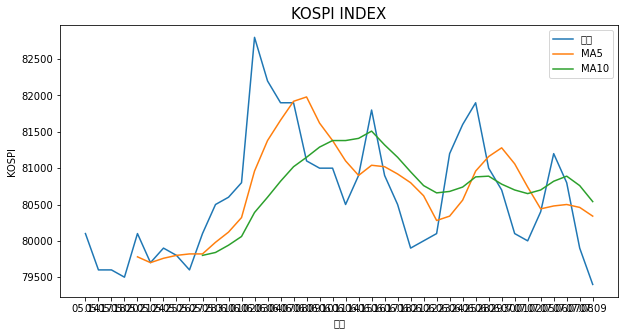

In [73]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title('KOSPI INDEX', fontsize=15)
ax.set_ylabel("KOSPI")
ax.set_xlabel("날짜")
ax.plot(kospi_df.index, kospi_df[['종가','MA5','MA10']])
ax.legend(['종가','MA5','MA10'])
plt.show()

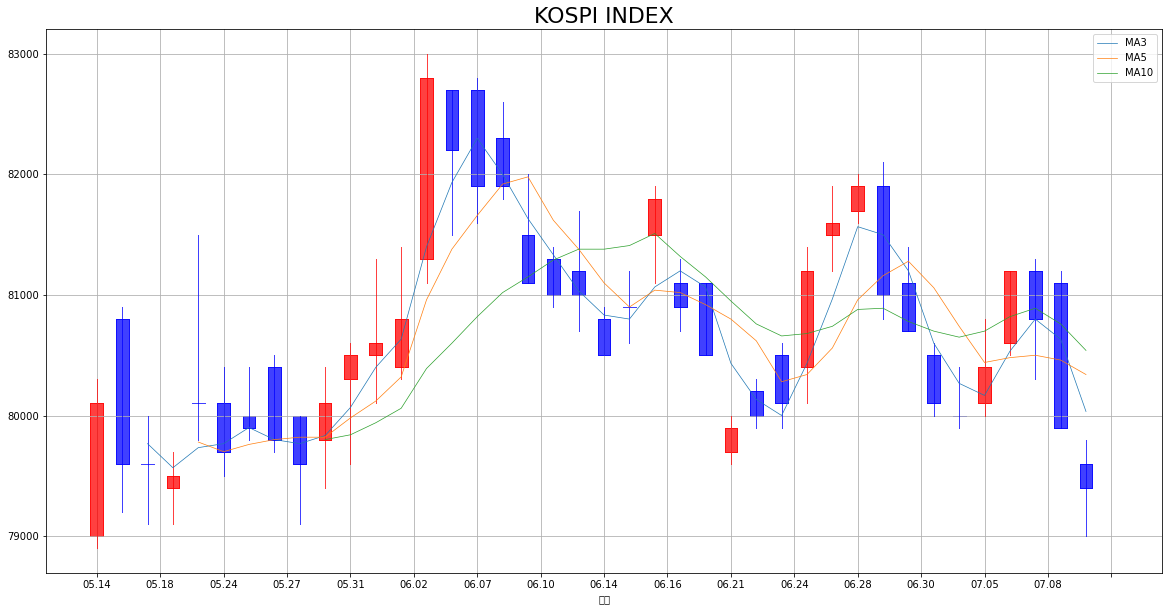

In [74]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
index = kospi_df.index.astype('str') # 캔들스틱 x축이 str로 들어감

# 이동평균선 그리기
ax.plot(index, kospi_df['MA3'], label='MA3', linewidth=0.7)
ax.plot(index, kospi_df['MA5'], label='MA5', linewidth=0.7)
ax.plot(index, kospi_df['MA10'], label='MA10', linewidth=0.7)

# X축 티커 숫자 20개로 제한
ax.xaxis.set_major_locator(ticker.MaxNLocator(20))

# 그래프 title과 축 이름 지정
ax.set_title('KOSPI INDEX', fontsize=22)
ax.set_xlabel('날짜')

# 캔들차트 그리기
candlestick2_ohlc(ax, kospi_df['시가'], kospi_df['고가'], 
                  kospi_df['저가'], kospi_df['종가'],
                  width=0.5, colorup='r', colordown='b')
ax.legend()
plt.grid()
plt.show()